In [1]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from imutils import build_montages
from imutils import paths
import random
import cv2

In [3]:
imagePaths = list(paths.list_images("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\train"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:21]

In [4]:
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)
# load the image and update the list of images
# construct the montages for the images
montages = build_montages(images, (128, 196), (7, 3))

In [5]:
labels = pd.read_csv("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\Training_set_covid.csv")

labels.head()
file_paths = [[fname, 'G:/PYTHON/Final year project/Final/covid_image_data/covid_image_data/train/' + fname] for fname in labels['filename']]

if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

Number of labels i.e.  3479 matches the number of filenames i.e.  3479


,filename,filepaths,label
0,Image_1.jpg,G:/PYTHON/Final year project/Final/covid_image...,1
1,Image_2.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
2,Image_3.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
3,Image_4.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
4,Image_5.jpg,G:/PYTHON/Final year project/Final/covid_image...,0


In [6]:
test_image_order = pd.read_csv("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\Testing_set_covid.csv")
test_image_order.head()

file_paths_test = [[fname, 'G:/PYTHON/Final year project/Final/covid_image_data/covid_image_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,G:/PYTHON/Final year project/Final/covid_image...
1,Image_2.jpg,G:/PYTHON/Final year project/Final/covid_image...
2,Image_3.jpg,G:/PYTHON/Final year project/Final/covid_image...
3,Image_4.jpg,G:/PYTHON/Final year project/Final/covid_image...
4,Image_5.jpg,G:/PYTHON/Final year project/Final/covid_image...


In [23]:
data = []
image_size = 128
test_pixel_data = []
import matplotlib.pyplot as plt

for i in range(len(train_data)):
    img_array = plt.imread(train_data['filepaths'][i], cv2.COLOR_BGR2RGB)

    new_img_array = cv2.resize(img_array, (image_size, image_size))
    #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
    data.append([new_img_array, train_data['label'][i]])


In [24]:
for i in range(len(test_images)):
    img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB)
    if img_array is None:
        print('Wrong path:', test_images['filepaths'][i])
    new_img_array = cv2.resize(img_array, (image_size, image_size))
    #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
    test_pixel_data.append(new_img_array)

In [25]:
np.random.shuffle(data)

In [26]:
x = []
y = []

counter = 406

for image in data:
    x.append(image[0])
    y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [27]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([3073,  406], dtype=int64))

In [28]:
pd.Series(y).value_counts()

0    3073
1     406
dtype: int64

In [29]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42,stratify=y)

In [30]:
test_pixel_data = np.array(test_pixel_data)

test_pixel_data = test_pixel_data/255

print(X_train.shape,X_val.shape,test_pixel_data.shape)

(2783, 128, 128, 3) (696, 128, 128, 3) (870, 128, 128, 3)


In [31]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,y_train,batch_size=8)

val_generator = val_datagen.flow(X_val,y_val,batch_size=8)

In [32]:
pd.Series(y_val).value_counts(normalize=True)

0    0.883621
1    0.116379
dtype: float64

In [33]:
print(X_train.shape,X_val.shape)

(2783, 128, 128, 3) (696, 128, 128, 3)


In [5]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [34]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

In [19]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [35]:
def build_model():
    model = Sequential()

    conv_base = DenseNet201(input_shape=(128,128,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
  # model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
  # model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
  # model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
        layer.trainable = True
 
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',"Precision","Recall"])

    return model

In [36]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 22,274,113
Trainable params: 22,037,121
Non-trainable params: 236,992
_________________________________________________________________


C:\Users\Charan Chandra\anaconda3\envs\gputest\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
with tf.device("GPU"):
    model.fit(train_generator,steps_per_epoch=87,epochs=100,validation_data=val_generator,validation_steps=22,callbacks=[cbs],class_weight={0:1,1:2})

Epoch 1/100
87/87 [==============================] - 60s 336ms/step - loss: 642.2299 - accuracy: 0.6710 - precision: 0.2721 - recall: 0.8421 - val_loss: 506.5297 - val_accuracy: 0.5568 - val_precision: 0.2143 - val_recall: 0.9545
Epoch 2/100
87/87 [==============================] - 25s 287ms/step - loss: 396.0991 - accuracy: 0.7543 - precision: 0.2731 - recall: 0.9118 - val_loss: 294.3685 - val_accuracy: 0.5284 - val_precision: 0.2000 - val_recall: 0.8696
Epoch 3/100
87/87 [==============================] - 31s 363ms/step - loss: 216.0331 - accuracy: 0.8201 - precision: 0.4103 - recall: 0.8889 - val_loss: 147.1613 - val_accuracy: 0.8920 - val_precision: 0.5000 - val_recall: 0.3158
Epoch 4/100
87/87 [==============================] - 26s 295ms/step - loss: 101.2069 - accuracy: 0.8218 - precision: 0.3904 - recall: 0.8795 - val_loss: 64.5221 - val_accuracy: 0.8409 - val_precision: 0.3611 - val_recall: 0.7222
Epoch 5/100
87/87 [==============================] - 22s 250ms/step - loss: 47.39

87/87 [==============================] - 41s 477ms/step - loss: 0.1779 - accuracy: 0.9899 - precision: 0.9663 - recall: 0.9556 - val_loss: 0.2269 - val_accuracy: 0.9602 - val_precision: 0.9333 - val_recall: 0.7000
Epoch 38/100
87/87 [==============================] - 42s 479ms/step - loss: 0.2165 - accuracy: 0.9856 - precision: 0.9294 - recall: 0.9518 - val_loss: 0.2290 - val_accuracy: 0.9489 - val_precision: 0.9091 - val_recall: 0.7407
Epoch 39/100
87/87 [==============================] - 43s 496ms/step - loss: 0.2226 - accuracy: 0.9828 - precision: 0.9157 - recall: 0.9383 - val_loss: 0.2704 - val_accuracy: 0.9489 - val_precision: 0.9167 - val_recall: 0.5789
Epoch 40/100
87/87 [==============================] - 41s 476ms/step - loss: 0.1956 - accuracy: 0.9943 - precision: 0.9756 - recall: 0.9756 - val_loss: 0.2135 - val_accuracy: 0.9602 - val_precision: 0.9231 - val_recall: 0.6667
Epoch 41/100
87/87 [==============================] - 42s 483ms/step - loss: 0.2583 - accuracy: 0.9799 - 

In [136]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


'1'

In [42]:
model.save("G:\\PYTHON\\Final year project\\Final\\covid_image_data\\covid_image_data\\dense_NET.h5")

In [38]:
preds = model.predict(X_val/255.0)
predictions = []
for i in preds:
    if i[0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [39]:
from sklearn.metrics import f1_score,confusion_matrix
print(f1_score(y_val,predictions))
print(confusion_matrix(y_val,predictions))

0.8433734939759034
[[600  15]
 [ 11  70]]


In [40]:
from sklearn.metrics import confusion_matrix,classification_report
target_names = ["COVID","Normal"]
print(classification_report(y_val,predictions, target_names=target_names))

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       615
      Normal       0.82      0.86      0.84        81

    accuracy                           0.96       696
   macro avg       0.90      0.92      0.91       696
weighted avg       0.96      0.96      0.96       696



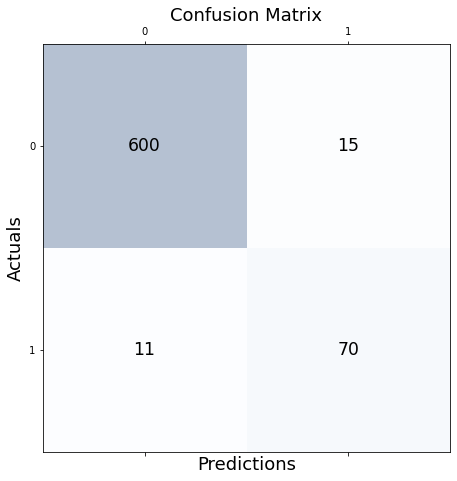

In [41]:
conf_matrix = confusion_matrix(y_val,predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [21]:
predictions = []
for i in preds:
    if i[0] > 0.8:
        predictions.append(1)
    else:
        predictions.append(0)

In [51]:
pd.Series(predictions).value_counts()

0    837
1     33
dtype: int64

In [ ]:
#print("Confidence : ",round(val[0][0]*100,2),"%")
#print(val)

In [53]:
result = pd.DataFrame(predictions,columns=['prediction'])

result.value_counts()

prediction
0             837
1              33
dtype: int64

In [1]:
from keras.models import load_model
model = load_model("G:\\PYTHON\\Final year project\\Final\\covid_image_data\\covid_image_data\\dense_NET.h5",
                  )

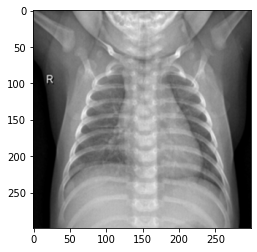

NORMAL


In [6]:
%matplotlib inline
# get sample image to test.
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_covid = 'G:\\PYTHON\\Final year project\\Dataset\\COVID-19_Radiography_Dataset\\COVID\\COVID-145.png'
img_normal = 'G:\\PYTHON\\Final year project\\Dataset\\COVID-19_Radiography_Dataset\\Normal\\Normal-111.png'


img_array = cv2.imread(img_normal)
plt.imshow(img_array)
#plt.imshow(image)
plt.show()
new_img_array = cv2.resize(img_array, (128, 128))
dt = []
dt.append(new_img_array)
X = np.array(dt)
X = X/255
val = model.predict(X)

if val > 0.5:
    print("COVID")
else:
    print("NORMAL")